In [1]:
! pip install pandas numpy matplotlib seaborn

Active code page: 1252
Defaulting to user installation because normal site-packages is not writeable


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", None)
sns.set_style("whitegrid")

In [6]:
DATA_PATH = "../data/raw/"

orders = pd.read_csv(DATA_PATH + "olist_orders_dataset.csv")
reviews = pd.read_csv(DATA_PATH + "olist_order_reviews_dataset.csv")
order_items = pd.read_csv(DATA_PATH + "olist_order_items_dataset.csv")
customers = pd.read_csv(DATA_PATH + "olist_customers_dataset.csv")
sellers = pd.read_csv(DATA_PATH + "olist_sellers_dataset.csv")

df = orders.merge(reviews, on="order_id", how="inner")
df["low_rating"] = (df["review_score"] <= 2).astype(int)

print("Dataset size:", df.shape)

Dataset size: (99224, 15)


In [11]:
df["low_rating"].value_counts(normalize=True)


low_rating
0    0.85311
1    0.14689
Name: proportion, dtype: float64

Low ratings represent ~14.7% of orders.
This is a moderately imbalanced classification problem.
Intervention potential is meaningful.

In [12]:
df["low_rating"].value_counts()

low_rating
0    84649
1    14575
Name: count, dtype: int64

Absolute numbers matter for business impact.


In [13]:
status_risk = df.groupby("order_status")["low_rating"].agg(["mean", "count"])
status_risk.sort_values("mean", ascending=False)

,mean,count
order_status,,
processing,0.925676,296
unavailable,0.847571,597
invoiced,0.817891,313
canceled,0.765189,609
shipped,0.693193,1043
created,0.666667,3
approved,0.500000,2
delivered,0.128133,96361


Orders that are cancelled or delayed may have higher low-rating risk.
Operational states are strong predictive candidates.

In [14]:
orders["order_purchase_timestamp"] = pd.to_datetime(orders["order_purchase_timestamp"])
orders["order_delivered_customer_date"] = pd.to_datetime(orders["order_delivered_customer_date"])
orders["order_estimated_delivery_date"] = pd.to_datetime(orders["order_estimated_delivery_date"])

orders["delivery_delay_days"] = (
    orders["order_delivered_customer_date"] -
    orders["order_estimated_delivery_date"]
).dt.days

df = df.merge(
    orders[["order_id", "delivery_delay_days"]],
    on="order_id",
    how="left"
)

df["delivery_delay_days"] = df["delivery_delay_days"].clip(-60, 30)

df.groupby("low_rating")["delivery_delay_days"].mean()

low_rating
0   -12.954433
1    -5.493522
Name: delivery_delay_days, dtype: float64

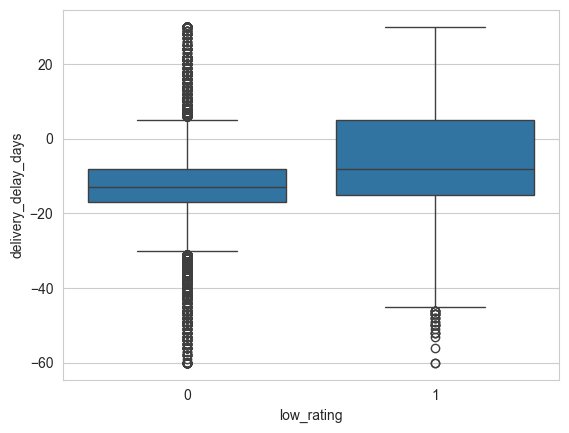

In [15]:
sns.boxplot(x="low_rating", y="delivery_delay_days", data=df)
plt.show()

In [16]:
price_df = order_items.groupby("order_id")[["price", "freight_value"]].sum().reset_index()

df = df.merge(price_df, on="order_id", how="left")

df.groupby("low_rating")[["price", "freight_value"]].mean()

,price,freight_value
low_rating,,
0,133.333298,22.035454
1,161.856994,27.418614


Higher-priced items may generate higher customer expectations, increasing dissatisfaction risk.

In [17]:
seller_order = order_items.merge(sellers, on="seller_id", how="left")

seller_risk = (
    seller_order.merge(df[["order_id", "low_rating"]], on="order_id")
    .groupby("seller_id")["low_rating"]
    .mean()
)

seller_risk.describe()

count    3090.000000
mean        0.183782
std         0.258013
min         0.000000
25%         0.000000
50%         0.100622
75%         0.235294
max         1.000000
Name: low_rating, dtype: float64

Seller heterogeneity exists.
A seller historical rating feature may improve predictive power.

In this notebook, I explored candidate signals that could help predict low review scores (review_score ≤ 2).

1. Target Distribution
Total reviewed orders: 99,224
Low rating orders: 14,575 (~14.7%)
Non-low rating orders: 84,649 (~85.3%)
This confirms a moderately imbalanced classification problem.

2. Order Status Risk
Orders grouped by order_status show significant variation in low-rating probability:
Cancelled, invoiced, unavailable, and processing orders show extremely high low-rating rates.
Delivered orders have a much lower low-rating rate (~12.8%).
This indicates operational state is a strong predictive signal.
However, some statuses (e.g., created, approved) have very small counts and may require careful handling during modeling.

3. Delivery Delay Impact

Mean delivery delay:
Non-low rating: -12.95 days
Low rating: -5.49 days
Orders receiving low ratings are delivered much closer to the estimated deadline.
This confirms delivery performance is a meaningful driver of dissatisfaction.
The boxplot further shows distributional separation between classes.
Delivery delay will be included as a core modeling feature.

4. Monetary Features (Price & Freight)
Average values:
Non-low rating:

Price ≈ 133.3
Freight ≈ 22.0

Low rating:
Price ≈ 161.9
Freight ≈ 27.4
Higher-priced orders and higher freight values are associated with higher dissatisfaction.
This suggests that customer expectations increase with transaction value.

5. Seller-Level Variation
Seller-level low-rating risk:
Mean seller risk ≈ 18.4%
Some sellers show extremely high low-rating proportions (max = 1.0)
This indicates strong seller heterogeneity.
Seller historical performance is a potential modeling feature.
Feature Shortlist for Modeling

Based on EDA, the following features will be considered:
delivery_delay_days
order_status
price
freight_value
seller-level historical risk

These features are:
Business-aligned
Supported by observed data signals
Operationally actionable
No unnecessary features will be added to avoid overfitting.